# Homework 5 - The eternal significance of publications and citations!

#### Group 15 <br>

<div style="float: left;">
    <table>
        <tr>
            <th>Student</th>
            <th>GitHub</th>
            <th>Matricola</th>
            <th>E-Mail</th>
        </tr>
        <tr>
            <td>André Leibrant</td>
            <td>JesterProphet</td>
            <td>2085698</td>
            <td>andre.leibrant@gmx.de</td>
        </tr>
        <tr>
            <td>Gianluca Procopio</td>
            <td>gianluca-24</td>
            <td>1942103</td>
            <td>procopio.1942103@studenti.uniroma1.it</td>
        </tr>
        <tr>
            <td>Susanna Bravi</td>
            <td>susannabravi</td>
            <td>1916681</td>
            <td>bravi.1916681@studenti.uniroma1.it</td>
        </tr>
        <tr>
            <td>Ahmad Saad</td>
            <td>ahmadsaaddm</td>
            <td>2133825</td>
            <td>ahmadsaaddm@gmail.com</td>
        </tr>
    </table>
</div>

#### Import Libraries and Modules

In [43]:
import ast
import csv
import json
import queue
import random
from collections import defaultdict
from collections import deque
from itertools import islice

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from tabulate import tabulate

plt.style.use("ggplot")

#### Constants

In [2]:
CIT_GRAPH = "citation"
COLLAB_GRAP = "collaboration"

## 1. Data
In this homework, you will work on a dataset that contains information about a group of papers and their citation relationships. You can find and download the dataset [here](https://www.kaggle.com/datasets/mathurinache/citation-network-dataset).

### Graphs setup
Based on the available data, you will create two graphs to model our relationships as follows:

1. **Citation graph:** This graph should represent the paper's citation relationships. We want this graph to be unweighted and directed. The citation should represent the citation given from one paper to another. For example, if paper A has cited paper B, we should expect an edge from node A to B.

2. **Collaboration graph:** This graph should represent the collaborations of the paper's authors. This graph should be weighted and undirected. Consider an appropriate weighting scheme for your edges to make your graph weighted.

### Data pre-processing
The dataset is quite large and may not fit in your memory when you try constructing your graph. So, what is the solution? You should focus your investigation on a subgraph. You can work on the most connected component in the graph. However, you must first construct and analyze the connections to identify the connected components.

As a result, you will attempt to approximate that most connected component by performing the following steps:

1. Identify the top **10,000 papers** with the <u>highest number of citations</u>.


2. Then the **nodes** of your graphs would be as follows:

    **Citation graph:** you can consider each of the papers as your nodes

    **Collaboration graph:** the authors of these papers would be your nodes


3. For the **edges** of the two graphs, you would have the following cases:

    **Citation graph:** only consider the citation relationship between these 10,000 papers and ignore the rest.

    **Collaboration graph:** only consider the collaborations between the authors of these 10,000 papers and ignore the rest.
    
---

We decided to read the large JSON file line by line and save the paper `id` with corresponding `n_citation` in a list.

---

In [52]:
# File path for papers json file
file_path = "data.json"

# List to store paper information
papers = []

# Open the papers json file
with open(file_path, "r") as file:
    
    # Iterate through every line of the file
    for line_number, line in enumerate(file):
        
        # Remove the leading comma
        if line.startswith(","):
            line = line[1:]
        
        # Skip the opening and ending braket
        if len(line) > 2:
            
            # Skip lines that have non-readable characters
            try:
            
                # Parse the json line
                data = json.loads(line)

                # Extract the id, references, and number of citations (set to 0 if doesn't exist)
                paper_id = data["id"]
                paper_references = data["references"]
                paper_citations = data.get("n_citation", 0)

                # Append the information to the list
                papers.append({"id": paper_id,
                               "references": paper_references,
                               "n_citations": paper_citations})
                
            except:
                pass

---

In the next step we sort the list by `n_citations`, extract the top 10,000 entries and convert the id key values to a list.

---

In [53]:
# Sort the list based on the number of citations
papers.sort(key=lambda paper: paper["n_citations"], reverse=True)

# Extract the top 10000 entries
top_10000_papers = papers[:10000]

# Convert id key values to list
paper_ids = [paper["id"] for paper in top_10000_papers]

---

Finally, we are going to iterate through the JSON file again and only extract the papers which are inside the top 10,000 list.

---

In [7]:
# Initialize an empty Pandas DataFrame
df_top_10000_papers = pd.DataFrame()

# Open the papers json file
with open(file_path, "r") as file:
    
    # Iterate through every line of the file
    for _, line in enumerate(file):
        
        # Remove the leading comma
        if line.startswith(","):
            line = line[1:]
        
        # Skip the opening and ending braket
        if len(line) > 2:
            
            # Skip lines that have non-readable characters
            try:
            
                # Parse the json line
                data = json.loads(line)

                # Only append if the id is from the top 10000 papers list
                if data["id"] in paper_ids:

                    # Load the json string into a temporary Pandas DataFrame
                    tmp_df = pd.read_json(line, lines=True)

                    # Append the temporary DataFrame to the main DataFrame
                    df_top_10000_papers = pd.concat([df_top_10000_papers, tmp_df], ignore_index=True)
            
            except:
                pass

---

We save the final result inside a CSV file, so that we don't have to always rerun the previous steps.

---

In [9]:
# Save results in CSV file
df_top_10000_papers.to_csv("top_10000_papers.csv", index=False)

---

We read the results inside the CSV file into a Pandas DataFrame for creating the citation and collaboration graphs.

---

In [5]:
# Read results from CSV file
df_top_10000_papers = pd.read_csv("top_10000_papers.csv")

---

First, we are going to create the citation (direct) graph using the paper's citation relationships. For this we extract all unique values between paper `ids` and `references` (which we convert from a string to a list of integers) and save the results inside `all_nodes`. Then we iterate through every paper, add the node if it is inside `all_nodes`, and add the edge between the `id` and `reference` if both are inside `all_nodes`.

---

In [6]:
# Drop all entries where the references field is empty
df_top_10000_papers = df_top_10000_papers.dropna(subset=["references"])

# Create an empty directed graph for the citations
citation_graph = nx.DiGraph()

# Get all unique paper ids
unique_ids = df_top_10000_papers["id"].unique()

# Extract all references and convert to a list of integers
reference_values = []
for references_str in df_top_10000_papers["references"]:
    references_list = ast.literal_eval(references_str)
    reference_values.extend(references_list)

# Get all unique values between both columns
all_nodes = set(unique_ids).union(set(reference_values))

# Add nodes and edges to the graph only for the nodes present in the file
for _, row in df_top_10000_papers.iterrows():
    paper_id = row["id"]
    references = ast.literal_eval(row["references"])
    
    # Add node if not already added
    if paper_id not in citation_graph.nodes:
        citation_graph.add_node(paper_id)
    
    # Add edges for references that are in the file
    for ref_id in references:
        if ref_id in all_nodes:
            citation_graph.add_edge(paper_id, ref_id)

---

In the next step we find the largest strongly connected component and save the result inside a subgraph.

---

In [7]:
# Get all strongly connected components
strongly_connected_components = nx.strongly_connected_components(citation_graph)

# Find the largest strongly connected component
largest_component = max(strongly_connected_components, key=len)

# Create a subgraph from the largest component
citation_subgraph = citation_graph.subgraph(largest_component)

---

We quickly plot the subgraph:

---

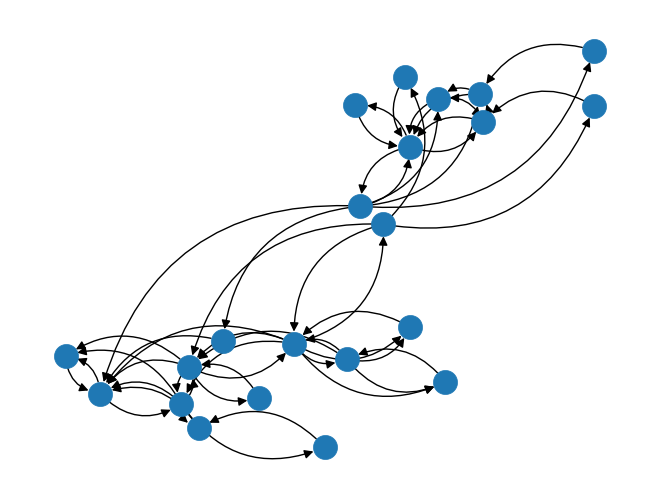

In [8]:
# Plot the subgraph
pos = nx.spring_layout(citation_subgraph)
nx.draw(citation_subgraph,
        pos,
        with_labels=False,
        arrowsize=13,
        connectionstyle="arc3, rad=0.4")

---

Next, we are going to create the collaboration (undirected and weigthed) graph using the collaborations of the paper's authors. For this we iterate through every paper and convert the authors list from a string to a list of dictionaries. Then we iterate through every pair of authors and add the nodes and edges if they don't exist yet. For the edge weight we decided to use the number of times two authors have collaborated. We are going to count the number of collaborations between each pair of authors and use that count as the weight.

---

In [9]:
# Create an empty undirected graph for the collaboration
collaboration_graph = nx.Graph()

# Iterate through each row in the DataFrame
for _, paper in df_top_10000_papers.iterrows():
    
    # Convert the string to a list of dictionaries
    authors_list = ast.literal_eval(paper["authors"])

    # Iterate through every pair of authors
    for i, author_i_dict in enumerate(authors_list):
        for j, author_j_dict in enumerate(authors_list[i+1:], start=i+1):
            
            # Retrieve author names
            author_i = author_i_dict["name"]
            author_j = author_j_dict["name"]
            
            # Initialize weight to 1
            weight = 1
            
            # Add nodes
            collaboration_graph.add_nodes_from([author_i, author_j])
            
            # Add edge if not already added and if yes, increase the weight by 1
            if not collaboration_graph.has_edge(author_i, author_j):
                collaboration_graph.add_edge(author_i, author_j, weight=weight)
                collaboration_graph[author_i][author_j]["titles"] = [paper["title"]]
            else:
                collaboration_graph[author_i][author_j]["weight"] += 1
                collaboration_graph[author_i][author_j]["titles"] += [paper["title"]]

In [10]:
# Get all connected components
connected_components = list(nx.connected_components(collaboration_graph))

# Find the largest connected component
largest_component = max(connected_components, key=len)

# Create a subgraph from the largest connected component
collaboration_subgraph = collaboration_graph.subgraph(largest_component)

---

**Note:** A graphical representation was not possible because the subgraph has 7324 nodes with 72875 edges!

---

# 2. Controlling system

Please keep the following in mind for both the backend and frontend components. The plan is to put in place a control system. You will provide the user with a menu from which he can select different functionalities. The user should be able to select from one of five different functionalities that you will implement in the following two sections. We want to have such a system so that the user can query different functionalities that he is interested in.

Your function should be designed in such a way that it provides the most flexibility to the user. For example, when the user selects functionality 1, which provides some high-level information about the graph, you can allow him to pass an argument indicating which of the two types of graphs he wants to be analyzed (That is why the name of the graph is one of the arguments in the first functionality).

You will implement the functionalities in the Backend section. The Frontend section primarily discusses the menu that you must provide to the user, as well as the expected results that should be displayed to the user after selecting each of the functionalities.

## 2.1. Backend Implementation

### Functionality 1 - Graph's features

Input:

- The graph
- The name of the graph

Output:

- The number of the nodes in the graph
- The number of the edges in the graph
- The graph density
- The graph degree distribution
- The average degree of the graph
- The graph hubs (hubs are nodes having degrees more extensive than the 95th percentile of the degree distribution)
- Whether the graph is dense or sparse

---

This function should examine a graph and report on some of its features. The input and report that this function should produce are shown below.
To retrieve these feautures we took advantages of some `Networkx` methods:

- **The number of the nodes in the graph**:
    - `graph.number_of_nodes()`
- **The number of the edges in the graph**:
    - `graph.number_of_edges()`
- **The graph density**:
    - `nx.density(graph)`
- **The graph degree distribution**:
    - For the undirected graph we can use the built in method `nx.degree_histogram(graph)`. For the directed graph the things became a bit tricky: We had to compute the histogram manually by finding the higher degree among the inwards and outwards edges and then we created two lists of zeros (of len max_degree+1) where each index represents a certain degree. In the end, we iterated over the values for both `in_degree` and `out_degree` and updated the two arrays
- **The average degree of the graph**:
    - To compute the average degree we first computed the degree of each node (`dict(graph.degree())`) and then we computed the mean (`sum(tot_degree.values()) / nodes_n`)
- **The graph hubs** (hubs are nodes having degrees more extensive than the 95th percentile of the degree distribution):
    - We computed the percentile and selected only the nodes whose degree was above the 95th percentile;
- **Whether the graph is dense or sparse**:
    - We fixed a threshold (`th=0.6`) and we decided that a graph is dense if the ratio between the number of edges and the max number of edges is above the threshold, otherwise it is sparse. The max number of edges is `n*(n-1)` if the graph is directed while it is `n*(n-1)/2` if the graph is undirected - _n_ is the number of nodes

In [10]:
def graph_features(graph,graph_name):
    
    nodes_n = graph.number_of_nodes()
    edge_n = graph.number_of_edges()
    density = nx.density(graph)
    
    if graph_name == COLLAB_GRAP:
        degree_dist = nx.degree_histogram(graph) # just use the built in method
    else: # compute the distribution of directed graph
        # compute the ingoing and the outgoing edges
        in_degrees = dict(graph.in_degree())
        out_degrees = dict(graph.out_degree())
        max_degree = max(max(in_degrees.values()), max(out_degrees.values()))
        # Create histograms for in-degrees and out-degrees
        # these lists helps us to save for each degree how many time we find it
        in_degree_hist = np.zeros(max_degree + 1, dtype=int)
        out_degree_hist = np.zeros(max_degree + 1, dtype=int)
        # manually create the histograms by counting for each degree how many time we found it
        for degree in in_degrees.values():
            in_degree_hist[degree] += 1
        for degree in out_degrees.values():
            out_degree_hist[degree] += 1
        # return it as  a tuple such that i can return just one variable
        degree_dist = (in_degree_hist,out_degree_hist)
    
    # compute the average degree
    tot_degree = dict(graph.degree())
    degree_avg = sum(tot_degree.values()) / nodes_n

    # compute hub, 95th percentile
    perc = np.percentile(list(tot_degree.values()),95)
    hub = [node_key for node_key, node_val in tot_degree.items() if node_val >= perc]
    # graph dense or sparse
    # max number of edges
    th = 0.6
    # compute the max number of edges paying attention if the graph is directed or undirected
    max_edges = nodes_n * (nodes_n - 1)/2 if graph_name == COLLAB_GRAP else nodes_n * (nodes_n - 1)
    is_dense = True if edge_n / max_edges >= th else False
  
    return nodes_n,edge_n,density,degree_dist,degree_avg,hub,is_dense

### Functionality 2 - Nodes' contribution

Using this functionality, you will identify the papers/authors who have significantly contributed to this field of study. For this analysis, focusing solely on the number of citations for the paper or the number of collaborations of the authors can be misleading. You will examine this using various centrality measurements.

Input:

- The graph
- A node of the graph (paper/author)
- The name of the graph

Output:

- The centrality of the node, calculated based on the following centrality measurements:
- [Betweeness](https://www.tandfonline.com/doi/abs/10.1080/0022250X.2001.9990249)
- [PageRank](https://courses.cs.washington.edu/courses/cse373/17au/project3/project3-3.html)
- [ClosenessCentrality](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.closeness_centrality.html#networkx.algorithms.centrality.closeness_centrality)
- DegreeCentrality

---

In order to compute these centrality measurements we took advantage of some Networkx methods that allow us to compute all these centrality for the given node in input.

In [11]:
def nodes_contribution(graph,node,graph_name):
    
    btwn = nx.betweenness_centrality(graph)[node]
    pr = nx.pagerank(graph)[node]
    clsn = nx.closeness_centrality(graph,u=node)
    dc = nx.degree_centrality(graph)[node]
    
    return btwn,pr,clsn,dc

### Functionality 3 - Shortest ordered walk

Input:

- The graph data
- A sequence of authors_a = \[a_2, ..., a_{n-1}\]
- Initial node a_1 and an end node a_n
- *N*: denoting the top *N* authors whose data should be considered

Output:

- The shortest walk of collaborations you need to read to get from author a_1 to author a_n and the papers you need to cross to realize this walk.

Considerations: For this functionality, you must implement an algorithm that returns the shortest walk that goes from node a_j to a_n, which visits in order the nodes in a. The choice of a_j and a_n can be made randomly (or if it improves the performance of the algorithm, you can also define it in any other way)

**Important Notes**:

- This algorithm should be run only on the collaboration graph.
- The algorithm needs to handle the case that the graph is not connected. Thus, only some nodes in a are reachable from a_1. In such a scenario, it is enough to let the program give in the output the string "There is no such path."
- Since we are dealing with walks, you can pass on the same node a_i more than once, but you must preserve order. It means you can go back to any author node any time you want, assuming that the order in which you visit the required nodes is still the same.
- Once you completed your implementation, ask chatGPT for a different one leveraging another approach in solving the shortest path and prove whether this implementation is correct.

---

Thus functionality works only on the Collaboration Graph, but despite it is a weighted graph, we used a BFS to commpute the shortest walk because if two authors collaborated to the same paper (hence, there is an edge between them) we assume that their distance is equal to 1. As a matter of fact, we are interested in the shortest walk and the weights does not represent distances: therefore we will compute the path with a BFS algorithm (Breadth First Search).

In this implementation of the BFS we kept track of the nodes through a queue which is initialized with a tuple containing the start node, the path from the start node (initialized with the start node itself), and an empty list for papers. Then there is the main loop that continues till the queue is empty: in each iteration we remove and return the first tuple of the queue (pop() method), we check if the current node is the end node (we've reached our destination), we mark the current node as visited and iterate over the neighbors of the current node. Each time we add a node to the queue, we keep up to date the path variable and the papers titles.  

This BFS is slightly revisited because beyond the path it returns also all the papers we crossed when looking for the right path.

In [11]:
def bfs_p(graph, start, end):
    
    # Initialize a queue with the start node
    queue = [(start, [start], [])]
    
    # Initialize an empty set to keep track of visited nodes
    visited = set()

    # Loop through until the end node is reached
    while queue:
        
        # Dequeue the current node to analyse and the current path from the queue
        current_node, path, papers = queue.pop(0)
        
        # Check if the current node is the end node
        if current_node == end:
            return path, papers
        
        # Mark the current node as visited
        visited.add(current_node)

        # Iterate through all neighbour nodes
        for neighbor in set(graph.neighbors(current_node)) - visited:
            
            # Each edge between two authors represent a papers, therefore we need to retrieve list of papers too
            titles = graph[current_node][neighbor]["titles"]
            
            # Enqueue the neighbor node and update the path
            queue.append((neighbor, path + [neighbor], papers + [titles[0]]))

    # Return None if no path was found
    return None, None

Below there is the main function we used to build the path. The main idea behind this function is that since we need to preserve the order of the given sequence of authors we will perform the BFS between 2 consecutive authors in the authors' sequence; with this idea, is more likely that our algorithm will visit the nodes in order. We later added a further check that makes us sure that the order is preserved.

In [12]:
def shortest_ordered_walk(graph, subsample):
    
    # initialize two empty arrays that will store the path to return and the papers
    path = []
    papers = []
    
    # the for loop goes from zero 
    for i in range(0, len(subsample)-1):
        # check if the nodes are in the subgraph we are considering. 
        # this will be useful only if we pick the subsample before we choose the top N.
        if subsample[i] not in graph.nodes():
            print("WARNING: This subsequence of nodes is not in the graph! \
                  Try to change N or check if the spelling is correct!")
            return None, None
        
        shortes_walk, titles = bfs_p(graph, subsample[i], subsample[i+1])
        # if no path was found, display a warning and return None, None
        if shortes_walk is None:
            print("WARNING: There is no such path!")
            return None, None
        else:
            # check if we didn't respect the order
            for auth in shortes_walk:
                try:
                    if auth in subsample[i+2:]:
                        print("WARNING: You didn't respect the order!")
                        return None, None
                except:
                    break
            # update the arrays to return
            if path == []:
                path = shortes_walk
                papers = titles
            else:
                path += shortes_walk[1:]
                papers += titles

    return path, papers

This is a code snippet we used to test our code. We decided to first extract the top N authors from the collaboration graph (N should be lower than the total number of nodes and we don't recommend to set it too high) and then, among the top N, we retrieved a random sample of size n (n lower than N) that will be our sequence of authors that we will look for.  

In order to find the top N we based our choice over the total number of collaboration (hence, the degree of the node), therefore we computed the degree for each node (each author) and sorted them based on the degree, in the end we selected the top N.  

Instead, when looking for the random sample, we selected all the top N nodes and extracted a random sample of size n, and we created a subgraph (with N nodes) over which we will run our algorithm.

In [13]:
# We choose an arbitrary N which has to be lower than the total number of nodes
N = 1000

degrees = dict(collaboration_graph.degree())
topN_authors = sorted(degrees.items(),key=lambda x:x[1],reverse=True)[:N]
topN_authors_aux = [el[0] for el in topN_authors]
graph_auth = collaboration_graph.subgraph(topN_authors_aux)

n = 7
random.seed(40)

subsample = random.sample(topN_authors_aux, n)

print("Subsample:")
for author in subsample:
    print(author)

path, papers = shortest_ordered_walk(graph_auth, subsample)

print('\nList of papers we crossed:')
for paper in papers:
    print(paper)

print('\nPath we found:')
for node in path:
    print(node)

Subsample:
Conor McMenamin
Sandra E. Orchard
Chris P Ponting
Tripti Gupta
Morana Vitezic
Jun Kawai
Ioannis Xenarios

List of papers we crossed:
InterPro in 2011: new developments in the family and domain prediction database
IntAct—open source resource for molecular interaction data
IntAct—open source resource for molecular interaction data
The InterPro Database, 2003 brings increased coverage and new features
The InterPro Database, 2003 brings increased coverage and new features
InterPro: the integrative protein signature database
Reference sequence (RefSeq) database at NCBI: current status, taxonomic expansion, and functional annotation
Reference sequence (RefSeq) database at NCBI: current status, taxonomic expansion, and functional annotation
InterPro: the integrative protein signature database
A promoter-level mammalian expression atlas
A promoter-level mammalian expression atlas
A promoter-level mammalian expression atlas
The InterPro protein families database: the classification r

---
#### ChatGPT implementation
---

In [14]:
def bfs_shortest_walk(graph, start, end):
    
    visited = set()
    q = queue.Queue()
    q.put((start, [start]))

    while not q.empty():
        
        current, path = q.get()

        if current == end:
            # Found the destination
            return path, get_papers_along_path(graph, path)

        visited.add(current)

        for neighbor in graph.neighbors(current):
            if neighbor not in visited and neighbor == path[len(path) - 1]:
                # Preserve order
                q.put((neighbor, path + [neighbor]))

    return None, None


def shortest_ordered_walk_chatGPT(graph, subsample):
    
    path = []
    papers = []

    for i in range(len(subsample) - 1):
        current_author = subsample[i]
        next_author = subsample[i + 1]

        if current_author not in graph.nodes():
            print("WARNING: This subsequence of nodes is not in the graph! \
                  Try to change N or check if the spelling is correct!")
            return

        shortest_walk, titles = bfs_shortest_walk(graph, current_author, next_author)

        if shortest_walk is None:
            print("\nWARNING: There is no such path!")
            return None, None

        if path == []:
            path = shortest_walk
            papers = titles
        else:
            # Skip the first node to avoid duplicates
            path += shortest_walk[1:]
            papers += titles

    return path, papers


def get_papers_along_path(graph, path):
    
    papers = []
    
    for i in range(len(path) - 1):
        papers.extend(graph[path[i]][path[i + 1]]['titles'])
        
    return papers

To test this code we used the same kind of code snippet we used in other implementations.

In [15]:
print("Subsample:")
for author in subsample:
    print(author)

path, papers = shortest_ordered_walk_chatGPT(graph_auth, subsample)

if papers and path:
    print('\nList of papers we crossed:')
    for paper in papers:
        print(paper)

    print('\nPath we found:')
    for node in path:
        print(node)

Subsample:
Conor McMenamin
Sandra E. Orchard
Chris P Ponting
Tripti Gupta
Morana Vitezic
Jun Kawai
Ioannis Xenarios



ChatGPT implementation is not working...   
We wrote a detailed prompt reporting the input, the desidered output and your indications. In the first place it didn't understand well the problem, therefore we showed it our implementation of the code and we asked for another solution more efficient but it couldn't give us any. We set a seed and used the same input in order to have a comparison between the 2 implementations. Its implementation is of course similar to ours but the bfs is implemented through a Queue, this can be a reasonable way to implement the BFS but in this case it doesn't work and so it doesn't find the shortest path.


### Functionality 4 - Disconnecting Graphs

Input:

- The graph data
- authorA: a paper to which will relate sub-graph G_a
- authorB: a paper to which will relate sub-graph G_b
- *N*: denoting the top *N* authors that their data should be considered

Output:

- The minimum number of edges (by considering their weights) required to disconnect the original graph in two disconnected subgraphs: G_a and G_b.

---

Here we implemented the minimum cut algorithm to disconnect the graph and identify two subgraph based on the two input nodes. We implemented a revised version of the Karger min cut algorithm where, once applied the contraction, we saved the removed node in the array which is saving the neighbors of the picked node.  

On each iteration of the algorithm we choose between the start or the target node, later we will choose one node in their neighborhood and we will append it to the neighborhood list. A copy of the original graph is needed because with the contraction we are going to shrink the graph each iteration, but we still need the original graph in order to properly compute the number of edges removed and to build the subgraphs which relate on the start and target node.

We added some check that avoid that if start and target are in their neighborhood, they can't be chosen.

In [15]:
def kargerMinCut(graph, start, target):
    
    # auxiliar lists that allows us to save the negihbor for the starter node and for the target node
    start_nb = []
    target_nb = []
    
    # i need a copy because later i need the original graph in order ro build the subgraph and computing the number of edges removed
    graph_copy = graph.copy()
    
    while len(graph_copy) > 2: # iterate till there are just 2 nodes
        
        # pick randomly between the start and the target
        v = random.choice([start,target])
        
        # the other node to use in the contraction is in the neighborhood of v but cant be neither the start or the target.
        w = random.choice(list(graph_copy.neighbors(v)))
        
        if w == start or w == target:
            continue

        graph_copy = nx.contracted_edge(graph_copy, (v, w))
        
        # if we are contracting with respect to the start node we will add w to start_nb, otherwise it'll be added to target_nb
        if v == start:
            start_nb.append(w)
        else:
            target_nb.append(w)

    # create the subgraph starting from the original graph and from the arrays containing the neighbors
    subgraph_start = nx.subgraph(graph,start_nb + [start])
    subgraph_target = nx.subgraph(graph,target_nb + [target])

    removed_edges = len(graph.edges) - len(subgraph_start.edges) - len(subgraph_target.edges)
    
    return removed_edges, subgraph_start, subgraph_target

To test our code we select 2 random authors out of the top N (N arbitrary chosen) based on their degrees.

In [16]:
N = 20
degrees = dict(collaboration_graph.degree())
topN_authors = sorted(degrees.items(),key=lambda x:x[1],reverse=True)[:N]
topN_authors_aux = [el[0] for el in topN_authors]
subgraph_auth = collaboration_graph.subgraph(topN_authors_aux)
n = 2
subsample = random.sample(list(subgraph_auth.nodes), n)
cnt = kargerMinCut(subgraph_auth.copy(),subsample[0],subsample[1])

### Functionality 5 - Extracting Communities

Input:

- The graph data
- *N*: denoting the top *N* papers that their data should be considered
- Paper_1: denoting the name of one of the papers
- Paper_2: denoting the name of one of the papers

Output:

- The minimum number of edges that should be removed to form communities
- A list of communities, each containing a list of papers that belong to them.
- Whether the Paper_1 and Paper_2 belongs to the same community.

**Important Notes**:<br>
To comprehend this functionality better, we suggest you take a good look at this [article](https://www.analyticsvidhya.com/blog/2020/04/community-detection-graphs-networks/)

---

Extracting communities from a graph refers to the process of identifying groups of nodes that are more densely connected with each other than with the rest of the nodes in the graph. Hence, a community is a subset of nodes with an higher connectivity compared to their connectivity with other nodes.  

In our implementation we try to find communities by iteratively removing edges with high betweenness centrality (i.e. edges that connect different parts of the graph).

In this case we need in input a full connected graph, hence we will work with the *citation_subgraph*; in fact we made a check over the number of connected components that if it's greater than 1 will end the function right away.
Moreover, our implementation requires that the input graph is undirected, so we need to transform it. 

Given that our implementation is based on the edge betweenness, we will compute the betweennes for each edge, we will sort them in descending order and then we will iteratively remove edges with the highest betweenness until the graph has more than just one connected component.  

In order to check if the two given papers ended up in the same community we first list all the communities (create a list with all the connected components) and then we iterate over the communities and check if the two papers are in the same community.

In the end we are request to return the number of removed edges too and so we first computed the number of nodes (through the Networkx method) at the start of the function and then we compute the difference when returning. 

In [17]:
def extracting_communities(graph, p1, p2):
    
    # We need an undirected graph
    graph_copy = graph.to_undirected()

    if nx.number_connected_components(graph_copy) > 1:
        print("The graph is not full connected!")
        return 0,[],False
    
    # Calculate the initial number of edges
    num_edges_start = graph_copy.number_of_edges()

    # Calculate betweenness centrality for each edge
    edge_betweenness = nx.edge_betweenness_centrality(graph_copy)

    # Sort edges by betweenness centrality in descending order
    sorted_edges = sorted(edge_betweenness.items(), key=lambda x: x[1], reverse=True)
    
    # Remove edges until the graph has more than one connected component
    while nx.number_connected_components(graph_copy) == 1:
        edge_to_remove = sorted_edges.pop(0)[0]
        graph_copy.remove_edge(*edge_to_remove)

    # Find connected components as communities
    communities = list(nx.connected_components(graph_copy))

    # Check if Paper_1 and Paper_2 belong to the same community
    same_community = any({p1, p2} <= community for community in communities)

    # Calculate the minimum number of edges removed
    num_edges_end = graph_copy.number_of_edges()
    
    # return a copy too that allows us to propery plot
    return num_edges_start-num_edges_end, communities, same_community, graph_copy 

Given that we need a full connected graph, we are using the citation subgraph, which is full connected but has only 22 nodes. For the sake of the test we choose 2 random papers among all the nodes.

In [18]:
# number of nodes we want to analyze
n = 2
subsample = random.sample(list(citation_subgraph.nodes), n)
print("Papers we want:",subsample[0],subsample[1])
min,cm,is_cm,g_copy = extracting_communities(citation_subgraph.copy(),subsample[0],subsample[1])
print("Edges to eliminate:",min)
print("Number of communities:",len(cm))
print("Are the paper in the same community?",is_cm)

Papers we want: 2055522016 2142646165
Edges to eliminate: 7
Number of communities: 2
Are the paper in the same community? True


## 2.2. Frontend Implementation

### Visualization 1 - Visualize graph features

We anticipate seeing the Functionality 1 report in Visualization 1. To be more specific, we expect you to have the following report format:

- A table containing the following general information about the graph:
    - Number of nodes in the graph
    - Number of the edges in the graph
    - Density of the graph
    - Average degree of the graph
    - Whether the network is sparse or dense
- A table that lists the graph's hubs
- A plot depicting the distribution of the citations received by papers (Citation graph)
- A plot depicting the distribution of the given citations by papers (Citation graph)
- A plot depicting the number of collaborations of the author (Collaboration graph)

**Note**: You can plot the features for a limited number of nodes (e.g., top 20) to improve the visualization of the plots.

In [20]:
def visualize_basic(graph,graph_name):
    
    nodes_n,edge_n,density,degree_dist,degree_avg,hub,is_dense = graph_features(graph,graph_name)
    
    if is_dense == 0:
        is_dense = 'Sparse'
    else:
        is_dense = 'Dense'
        
    data = {"Number of nodes": nodes_n,"Number of edges": edge_n,"Density": density,"Average degree": degree_avg,"Dense or Sparse": is_dense}
    df = pd.DataFrame(data, index =[0])
    
    formatted_df = df.style.format(precision=3, thousands=".", decimal=",").format_index(str.upper, axis=1)
    print("------------------------------------TABLE OF STATISTICS------------------------------------")
    display(formatted_df)
    
    print("\n")
    
    print("------------------------------------TABLE OF HUBS-----------------------------------------")
    data_hub = pd.DataFrame({"HUB NODES" : hub})
    display(data_hub)
    
    if graph_name == COLLAB_GRAP:
        #Plot depicting the number of collaborations of the author 
        df_degree = pd.DataFrame({'Degree': range(len(degree_dist)), 'Count': degree_dist})
        # To not have 0 values otherwise the log scale will not work
        df_degree_filtered = df_degree[df_degree['Count'] > 0]
        print("\n")
        print("------------------------------------PLOT OF THE DEGREE------------------------------------")
        plt.figure(figsize=(6, 5))
        plt.bar(df_degree_filtered['Degree'], df_degree_filtered['Count'], log=True, width=3, color='#3D52D5', alpha=1)
        plt.title('Degree Distribution - Log Scale')
        plt.xlabel('Degree')
        plt.ylabel('Count (Log Scale)')
        plt.show()
    
    elif graph_name == CIT_GRAPH:
        in_deg , out_deg = degree_dist 
        df_degree_in = pd.DataFrame({'Degree': range(len(in_deg)), 'Count': in_deg})
        # To not have 0 values otherwise the log scale will not work
        df_degree_in_filtered = df_degree_in[df_degree_in['Count'] > 0]
        # Plot with log scale
        print("\n")
        print("-----------------------------------------------------------PLOT OF THE DEGREE-----------------------------------------------------------")
        fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # Modifica la dimensione se necessario
        df_degree_out = pd.DataFrame({'Degree': range(len(out_deg)), 'Count': out_deg})
        # To not have 0 values otherwise the log scale will not work
        df_degree_out_filtered = df_degree_out[df_degree_out['Count'] > 0]
        axs[0].bar(df_degree_in_filtered['Degree'], df_degree_in_filtered['Count'], log=True, width=3, color='#3D52D5', alpha=1)
        axs[0].set_title('Inward Degree Distribution - Log Scale')
        axs[0].set_xlabel('Inward Degree')
        axs[0].set_ylabel('Count (Log Scale)')
        axs[1].bar(df_degree_out_filtered['Degree'], df_degree_out_filtered['Count'], log=True, width=4, color='#3D52D5', alpha=1)
        axs[1].set_title('Outward Degree Distribution - Log Scale')
        axs[1].set_xlabel('Outward Degree')
        axs[1].set_ylabel('Count (Log Scale)')
    
    return 

------------------------------------TABLE OF STATISTICS------------------------------------


,NUMBER OF NODES,NUMBER OF EDGES,DENSITY,AVERAGE DEGREE,DENSE OR SPARSE
0,99.914,187.027,"0,000","3,744",Sparse




------------------------------------TABLE OF HUBS-----------------------------------------


,HUB NODES
0,1699105
1,1604454960
2,1660562555
3,2109394932
4,2151511199
...,...
5037,2896457183
5038,2897840903
5039,2912601938
5040,2913535645




-----------------------------------------------------------PLOT OF THE DEGREE-----------------------------------------------------------


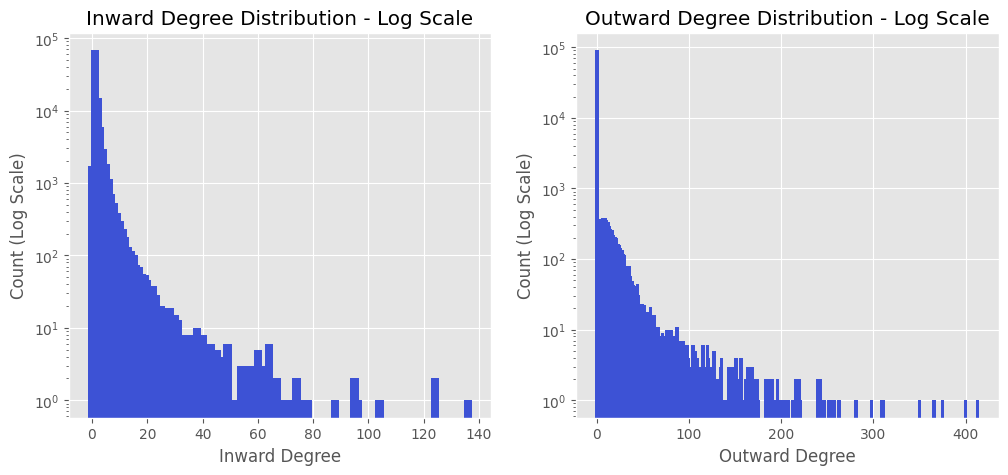

In [21]:
visualize_basic(citation_graph, CIT_GRAPH)

We have given the example of the visualization of Citation Graph statistics thus a directed and unweighted graph.

In the first table there are basic statistics such as the number of nodes, which in this case is 99914, and the number of arcs, which is 187027.                         

In the second table are all the nodes that are hubs i.e., nodes having degrees more extensive than the 95th percentile of the degree distribution.             

In order to see the degree distribution of the graph we made two graphs representing both the in-degree and the out-degree.                   

It was necessary to use the logarithmic scale in the y-axis because many nodes had a low degree and few nodes had a very high degree. We felt it was better to use the logarithmic scale than to cut the data because in a graph a node with so many arcs is not to be considered an outlier but is instead an important node.                       

### Visualization 2 - Visualize the node's contribution

We anticipate seeing the Functionality 2 report in Visualization 2. To be more specific, we expect you to have the following report format:

- A table containing the node's centrality value based on the four centrality measurements

In [28]:
def visualize_centrality(graph, node, graph_name):
    
    btwn,pr,clsn,dc = nodes_contribution(graph, node, graph_name)
    data = {"Betweenness Centrality": btwn,"Pagerank": pr,"Closeness Centrality": clsn,"Degree Centrality": dc}
    df = pd.DataFrame(data, index =[0])
    
    formatted_df = df.style.format(precision=3, thousands=".", decimal=",").format_index(str.upper, axis=1)
    print("------------------------------- TABLE OF CENTRALITIES OF NODE", node, "-------------------------------")
    display(formatted_df)

In [29]:
visualize_centrality(citation_subgraph, 2139212933, CIT_GRAPH)

------------------------------- TABLE OF CENTRALITIES OF NODE 2139212933 -------------------------------


,BETWEENNESS CENTRALITY,PAGERANK,CLOSENESS CENTRALITY,DEGREE CENTRALITY
0,"0,048","0,037","0,219","0,238"


We chose a random node from the Citation graph and with this visualization you can see 4 types of centrality: Betweenness Centrality, Pagerank, Closeness Centrality and Degree Centrality.           From the previous visualization and the degree plot shown we did not expect to find high values of these measures and in fact the node has all values less than 0.25

### Visualization 3 - Visualize the shortest-ordered route

We anticipate seeing the Functionality 3 report in Visualization 3. To be more specific, we expect you to have the following report format:

- Print the papers needed to be crossed in the shortest walk in order
- Plot the graph and identify the nodes and edges that appear in the shortest walk (please put an identifier on each edge in the shortest walk to determine the order that we should have the walk)

In [40]:
def visualize_shortest_ordered_route(graph, subsample):
    
    path, papers = shortest_ordered_walk(graph, subsample)
    
    N = 20
    degrees = dict(graph.degree())
    topN_authors = sorted(degrees.items(),key=lambda x:x[1],reverse=True)[:N]
    topN_authors_aux = [el[0] for el in topN_authors]
    graph_auth = graph.subgraph(topN_authors_aux + path)
    
    if not path or not papers:
        return
    
    print('\nList of papers we crossed:')
    
    for paper in papers:
        print(paper)
        
    font_size = 8  
    lista_edge = [(path[i], path[i+1]) for i in range(len(path)-1)]
    edge_colors = ['#3D52D5' if (u, v) in lista_edge or (v, u) in lista_edge else 'lightgray' for u, v in graph_auth.edges()]

    # This is a better position for seeing the path in our case
    pos = nx.circular_layout(graph_auth) 

    nx.draw(graph_auth, with_labels=True, font_size=font_size, edge_color=edge_colors, node_color="orange", pos=pos)
    plt.title('Shortest Path')

    # Add edge labels for both directions
    edge_labels = {}
    for i, (u, v) in enumerate(zip(path[:-1], path[1:])):
        key = (u, v)
        if key in edge_labels:
            edge_labels[key] += f", {i+1}"
        else:
            edge_labels[key] = f"{i+1}"
        
        key = (v, u)
        if key in edge_labels:
            edge_labels[key] += f", {i+1}"
        else:
            edge_labels[key] = f"{i+1}"
        
    nx.draw_networkx_edge_labels(graph_auth, pos=pos, edge_labels=edge_labels, font_color="red")
    plt.show()


List of papers we crossed:
InterPro in 2011: new developments in the family and domain prediction database
IntAct—open source resource for molecular interaction data
IntAct—open source resource for molecular interaction data
The InterPro Database, 2003 brings increased coverage and new features
The InterPro Database, 2003 brings increased coverage and new features
InterPro: the integrative protein signature database
Reference sequence (RefSeq) database at NCBI: current status, taxonomic expansion, and functional annotation
Reference sequence (RefSeq) database at NCBI: current status, taxonomic expansion, and functional annotation
InterPro: the integrative protein signature database
A promoter-level mammalian expression atlas
A promoter-level mammalian expression atlas
A promoter-level mammalian expression atlas
The InterPro protein families database: the classification resource after 15 years


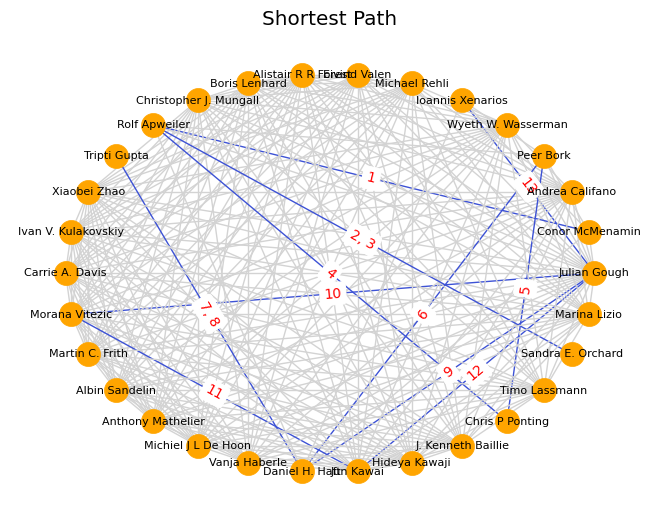

In [41]:
subsample = [
    "Conor McMenamin",
    "Sandra E. Orchard",
    "Chris P Ponting",
    "Tripti Gupta",
    "Morana Vitezic",
    "Jun Kawai",
    "Ioannis Xenarios"
]

visualize_shortest_ordered_route(collaboration_graph, subsample)

The function for visualization takes as input the graph and a sequence of authors.

The start node and end node are the first and last authors in the given sequence. We tested the code with the subgraph of the collaboration graph so as to make sure we have a connected graph.

### Visualization 4 - Visualize the disconnected graph

We anticipate seeing the Functionality 4 report in Visualization 4. To be more specific, we expect you to have the following report format:

- Print the number of the links that should be disconnected
- Plot the original graph
- Plot the graph after removing the links and identify the two nodes

In [42]:
def visualize_disconnected_graph(graph,node_a,node_b,N):
    
    degrees = dict(graph.degree())
    topN_authors = sorted(degrees.items(),key=lambda x:x[1],reverse=True)[:N]
    topN_authors_aux = [el[0] for el in topN_authors]
    subgraph_auth = graph.subgraph(topN_authors_aux)
    pos1 = nx.spring_layout(subgraph_auth)
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
    axes[0].set_title('Original graph')
    axes[1].set_title('Subgraph related to ' + node_a)
    axes[2].set_title('Subgraph related to '+ node_b)
    
    nx.draw(subgraph_auth, pos = pos1, ax = axes[0], node_color = "orange",edge_color = "gray")
    num_edges, sub_start, sub_target = kargerMinCut(subgraph_auth.copy(),node_a,node_b)
    node_colors_a = ['red' if node == node_a else 'orange' for node in sub_start.nodes]
    print("The number of edges cutted is:", num_edges)
    pos2 = nx.spring_layout(sub_start)
    nx.draw(sub_start, pos = pos2, ax=axes[1], node_color = node_colors_a, edge_color = "gray")

    node_colors_b = ['red' if node == node_b else 'orange' for node in sub_target.nodes]
    pos3 = nx.spring_layout(sub_target)
    nx.draw(sub_target, pos = pos3, ax=axes[2], node_color = node_colors_b, edge_color = "gray")

The number of edges cutted is: 100


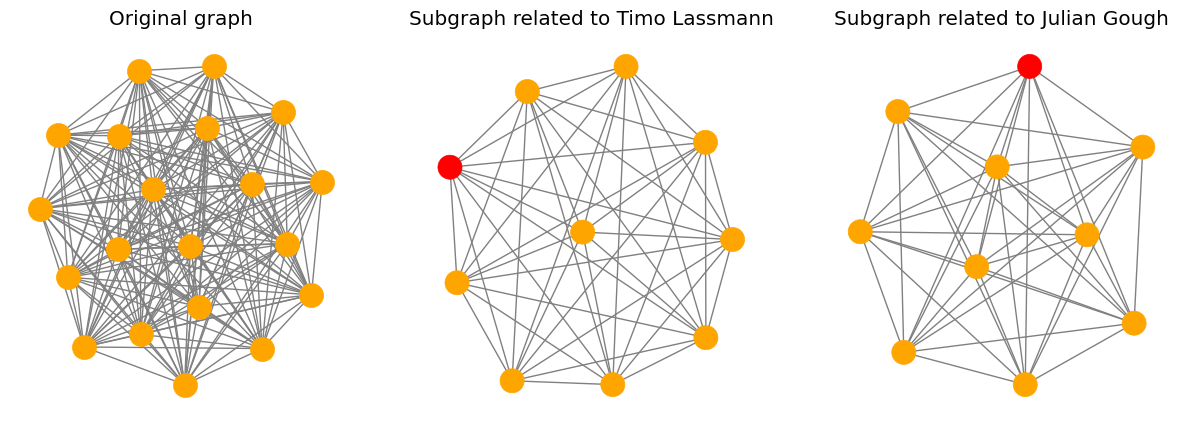

In [38]:
N = 20
nodes = ['Timo Lassmann', 'Julian Gough']

visualize_disconnected_graph(collaboration_graph, nodes[0], nodes[1], N)

As requested, we first made a printout of the number of edges cut to find the two subgraphs, and in this case 100 edges were cut. We then represented the starting graph and the two obtained subgraphs by highlighting in red the nodes concerning the two selected authors.

### Visualization 5 - Visualize the communities

We anticipate seeing the Functionality 5 report in Visualization 5. To be more specific, we expect you to have the following report format:

- Print the number of links that should be removed to have the communities
- A table depicting the communities and the papers that belong to each community
- Plot the original graph
- Plot the graph showing the communities in the network
- Plot the final graph and identify the community/communities of Paper_1 and Paper_2

In [39]:
def visualize_communities(graph,node1,node2):
    
    min_edge,cm,is_cm,g_copy = extracting_communities(graph,node1,node2)
    print("------------------------------- NUMBER OF EDGES -------------------------------")
    print("Edges to eliminate:",min_edge)
    print("------------------------------- TABLE OF COMMUNITIES -------------------------------")
    cm_2 = [list(community)[:4] + ['...'] if len(community) > 4 else list(community) for community in cm]

    df = pd.DataFrame({"Index": range(len(cm_2)), "Set": cm_2})

    table = tabulate(df, headers='keys', tablefmt='pretty', showindex=False)
    print(table)
    print("---------------------------------------------------------------------------------")
    # Preapre the layouts for the plots such that they don't overlap
    pos1 = nx.spring_layout(graph)
    pos2 = nx.spring_layout(graph)
    pos3 = nx.spring_layout(g_copy)

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

    axes[0].set_title('Plot the original graph')
    axes[1].set_title('Plot the communities in the graph')
    axes[2].set_title('Plot the final graph')

    # PLOT THE GRAPH
    nx.draw(graph,pos=pos1, ax=axes[0])
    # PLOT THE COMMUNITIES
    node_colors = [community_id for community_id, nodes in enumerate(cm) for node in nodes]
    nx.draw(graph, pos=pos2, node_color=node_colors, cmap=plt.cm.rainbow, ax=axes[1])
    # PLOT THE FINAL GRAPH
    node_labels = {node: f'Cm.{community_id}' for community_id, nodes in enumerate(cm) for node in nodes} # label with the community id for the nodes
    node_colors = ['red' if node in subsample else 'blue' for node in g_copy.nodes]

    nx.draw(g_copy,pos=pos3,node_color=node_colors, cmap=plt.cm.rainbow,labels=node_labels, ax=axes[2])

------------------------------- NUMBER OF EDGES -------------------------------
Edges to eliminate: 7
------------------------------- TABLE OF COMMUNITIES -------------------------------
+-------+---------------------------------------------------------+
| Index |                           Set                           |
+-------+---------------------------------------------------------+
|   0   | [2132549764, 2139212933, 2092654472, 2142646165, '...'] |
|   1   |                      [2127713198]                       |
+-------+---------------------------------------------------------+
---------------------------------------------------------------------------------


c:\Python\Lib\site-packages\networkx\drawing\nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


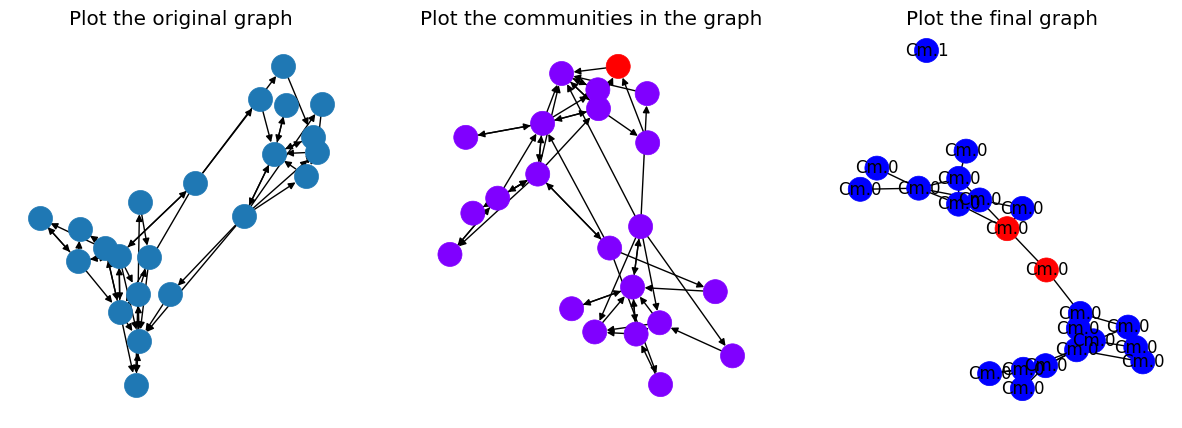

In [40]:
n = 2
subsample = random.sample(list(citation_subgraph.nodes), n)
visualize_communities(citation_subgraph.copy(),subsample[0],subsample[1])

We showed only 4 elements per row in order to keep the plot tidy, but in the first row there are actually 21 nodes to display. Given that in the second community there is just one element, we find this the better and cleaner way to plot it.

## 3. Bonus - PageRank on MapReduce 

**IMPORTANT**: This is a bonus step, so it's <u>not mandatory</u>. You can get the maximum score without doing this. We will consider this, **only if** the rest of the homework has been completed.

Working with big data has become increasingly important in the modern era as the volume and complexity of data generated grows. In this part, we ask you to **implement the PageRank algorithm using MapReduce paradigm** to compute the <u>importance of papers</u> based on the citation relationship. 

Since a large dataset is required to fully understand the power of this paradigm, when creating the Citation graph, consider the **top 1,000,000 papers** that have received the most citations; then, make the graph exclusively for those papers. 

**Hint:**
[Here](https://www.cs.utah.edu/~jeffp/teaching/cs5140-S15/cs5140/L24-MR+PR.pdf) are **two approaches** to implement the PageRank algorithm using the MapReduce paradigm that you can use as a reference for your bonus part.

---

First, we are going to extract the top 1,000,000 papers based on their citations.

In [54]:
top_1000000_papers = papers[:1000000]

In the next step we create the new citation graph.

In [55]:
# Create an empty directed graph for the citations
bonus_citation_graph = nx.DiGraph()

# Get all unique paper ids
unique_ids = set()

# Extract all references and convert to a list of integers
reference_values = []

for paper in top_1000000_papers:
    paper_id = paper["id"]
    references_list = paper["references"]
    
    # Add node if not already added
    if paper_id not in bonus_citation_graph.nodes:
        bonus_citation_graph.add_node(paper_id)
        unique_ids.add(paper_id)
    
    # Add edges for references that are in the file
    for ref_id in references_list:
        if ref_id in unique_ids:
            bonus_citation_graph.add_edge(paper_id, ref_id)
        reference_values.append(ref_id)

Due to the fact we didn't have enough resources in AWS EMR to process the large amount of data, we implemented a simplified MapReduce function in Python.

In [56]:
def map_function(node, pagerank, outlinks):
    """
    This function is responsible for emitting key-value pairs for each node and its outlinks. If a node has no 
    outlinks (called dangling node), it yields a special key ("dangling_node") along with the PageRank of the node.
    Otherwise, it yields each outlink of the node along with the fraction of the node's PageRank that should be 
    passed on to the outlink.

    Parameters:
    node (str): The current node being processed.
    pagerank (float): The PageRank of the current node.
    outlinks (list): The list of nodes that the current node links to.

    Yields:
    tuple: A tuple containing a key (an outlink or a special key for dangling nodes) and a value (the PageRank 
    to be passed on).
    """
   
    # Check if the node has any outlinks
    if not outlinks:
        # If the node has no outlinks, emit a special key ("dangling_node") along with the PageRank of the node
        yield ("dangling_node", pagerank)
    else:
        # If the node has outlinks, emit each outlink along with the fraction of the node's PageRank that should be passed on to the outlink
        for outlink in outlinks:
            yield (outlink, pagerank / len(outlinks))

In [57]:
def reduce_function(node, values, betha, dangling_mass, total_nodes):
    """
    This function is responsible for computing the new PageRank value for a given node. The new PageRank value is
    calculated as a weighted combination of the old PageRank value and the PageRanks of the nodes that link to it,
    plus a portion of the total PageRank that is distributed uniformly across all nodes (the damping factor).

    Parameters:
    node (str): The current node being processed.
    values (list): The list of PageRanks of the nodes that link to the current node.
    betha (float): The damping factor.
    dangling_mass (float): The total PageRank of all dangling nodes.
    total_nodes (int): The total number of nodes in the graph.

    Returns:
    new_pagerank (float): The new PageRank value for the current node.
    """
  
    # Compute the new PageRank value for the current node
    new_pagerank = (1 - betha) / total_nodes + betha * (sum(values) + (dangling_mass / total_nodes))
  
    return new_pagerank

In [58]:
def has_converged(old_pagerank, new_pagerank, threshold):
    """
    This function compares the absolute difference between the old and new PageRank values of each node. If the
    difference exceeds a certain threshold for any node, the function returns False, indicating that the algorithm
    has not yet converged. If the difference is less than or equal to the threshold for all nodes, the function
    returns True, indicating that the algorithm has converged.

    Parameters:
    old_pagerank (dict): Dictionary storing the old PageRank values for each node.
    new_pagerank (dict): Dictionary storing the new PageRank values for each node.
    threshold (float): The convergence threshold.

    Returns:
    bool: True if the algorithm has converged, False otherwise.
    """

    # Loop through each node in the old PageRank values
    for node in old_pagerank:
        
        # If the absolute difference between the old and new PageRank values of the node exceeds the threshold,
        # return False
        if abs(old_pagerank[node] - new_pagerank[node]) > threshold:
            return False

    # If the function hasn't returned False by this point, it means the absolute difference for all nodes is less
    # than or equal to the threshold
    return True

In [59]:
def shuffle_function(mapped_values):
    """
    This function takes a list of tuples, where each tuple contains a key and a value.
    It groups the values by their keys and returns a dictionary where each key is associated with a list of values.

    Parameters:
    mapped_values (list): A list of tuples, where each tuple contains a key and a value.

    Returns:
    dict: A dictionary where each key is associated with a list of values.
    """

    # Create a defaultdict with lists as default values
    groups = defaultdict(list)

    # Loop through each key-value pair in the mapped values
    for key, value in mapped_values:
        
        # Append the value to the list of values associated with the key
        groups[key].append(value)

    # Convert the defaultdict to a regular dict and return it
    return dict(groups)

In [ ]:
# Set initial PageRank values for each node
initial_pagerank = 1.0 / len(bonus_citation_graph)
pagerank_values = {node: initial_pagerank for node in bonus_citation_graph}

# Maximum number of iterations
iterations = 10

# Damping factor
beta = 0.85

# Convergence threshold to determine when to stop
convergence_threshold = 1.0e-6

# Variable to track whether the algorithm has converged
converged = False

# MapReduce
for i in range(iterations):
    
    # Map phase
    mapped_values = []
    for node, pagerank in pagerank_values.items():
        outlinks = list(bonus_citation_graph.successors(node))
        map_results = map_function(node, pagerank, outlinks)
        mapped_values.extend(map_results)

    # Shuffle phase
    shuffled_values = shuffle_function(mapped_values)
    
    # Calculate total dangling mass
    dangling_mass = len(shuffled_values["dangling_node"]) * initial_pagerank

    # Reduce phase
    new_pagerank_values = {}
    for node, pagerank_list in shuffled_values.items():
        if node != "dangling_node":
            new_pagerank = reduce_function(node, pagerank_list, beta, dangling_mass, len(bonus_citation_graph))
            new_pagerank_values[node] = new_pagerank
        else:
            # Handle dangling nodes by redistributing their mass to all nodes
            for dangling_target in bonus_citation_graph:
                if dangling_target not in new_pagerank_values:
                    new_pagerank_values[dangling_target] = 0
                new_pagerank_values[dangling_target] += dangling_mass / len(bonus_citation_graph)
        
    # Check for convergence
    if has_converged(pagerank_values, new_pagerank_values, convergence_threshold):
        break
    else:
        # Update pagerank values for the next iteration
        pagerank_values = new_pagerank_values

In [66]:
# Print the first 10 nodes with their calculated PageRank
for key, value in list(islice(pagerank_values.items(), 10)):
    print(f"{key}: {value}")

2151103935: 0.0003053861675917576
2911964244: 0.00018407223162556773
2153635508: 0.00020619615715423154
1791587663: 0.0004802571571261314
2119821739: 0.0005012520925403999
2103441770: 1.7389195627341097e-05
2126105956: 7.118547122519003e-05
2146058063: 6.605980470416635e-06
2145023731: 0.000614953033385674
2161969291: 9.685936722442147e-05


## 4. Command Line Question (CLQ)
In this question, you should use any command line tools that you know to answer the following questions using the **directed** and **unweighted graph** that you have previously created: **Citation graph**:

---

We are going to use the largest strongly connected component and save the subgraph inside a file which we are going to use in the Command Line. We decided to work on the subgraph for computation time reasons.

---

In [ ]:
nx.write_edgelist(citation_subgraph, "citation_subgraph.edgelist", data=False)

---

The shell script is saved in the file `CommandLine.sh`. First you need to navigate to the file where the `scitation_subgraph.edgelist` file is saved by using the `cd` command and then you can run the script with the `./CommandLine.sh` command (before that you have to make sure that it is executable by using the `chmod +x CommandLine.sh` command).

---

1. Is there any node that acts as an important "connector" between the different parts of the graph?

To identify a possible important connector we are going to calculate the betweenness centrality for each note:

```bash
# Calculate betweenness centrality for each node
python -c "import networkx as nx; citation_subgraph = nx.read_edgelist('citation_subgraph.edgelist', create_using=nx.DiGraph()); print('\n'.join([f'{node} {centrality}' for node, centrality in nx.betweenness_centrality(citation_subgraph).items()]))" > betweenness_centrality.txt

# Sort nodes by betweenness centrality in descending order
sort -k2 -rn betweenness_centrality.txt > sorted_betweenness_centrality.txt

# Print the top connectors
head -n 10 sorted_betweenness_centrality.txt
```

![Screenshot1](img/Screenshot1.png)

---

**Conclusion:** The node with the paper id `2121127625` has a betweenness centrality score of 0.51 which indicates that, on average, half of the shortest paths in the graph pass through that specific node. The nodes with the paper ids `2032210760`, `2107890099`, and `1975846642` have a similar importance.

---

2. How does the degree of citation vary among the graph nodes?

Because not specified we are going to analyze the in-degrees and out-degrees of each node. In our context the in-degrees represent the number of times a paper has been cited and the out-degrees represent the number of citations made by that paper.

```bash
# Calculate in-degree and out-degree for each node and print the largest and smallest value for each type of degree
python -c "import networkx as nx; citation_subgraph = nx.read_edgelist('citation_subgraph.edgelist', create_using=nx.DiGraph()); in_degrees = sorted(citation_subgraph.in_degree(), key=lambda x: x[1], reverse=True); out_degrees = sorted(citation_subgraph.out_degree(), key=lambda x: x[1], reverse=True); print(f'Largest In-Degree: {in_degrees[0][0]} {in_degrees[0][1]}'); print(f'Lowest In-Degree: {in_degrees[-1][0]} {in_degrees[-1][1]}'); print(f'Largest Out-Degree: {out_degrees[0][0]} {out_degrees[0][1]}'); print(f'Lowest Out-Degree: {out_degrees[-1][0]} {out_degrees[-1][1]}')"
```

![Screenshot2](img/Screenshot2.png)

---

**Conclusion:** Both type of degrees vary between 1 and 7.

---

3. What is the average length of the shortest path among nodes?

For this we can straight forward use the inbuild function `average_shortest_path_length` from `networkx`.

```bash
# Calculate average length of the shortest path among nodes
python -c "import networkx as nx; citation_subgraph = nx.read_edgelist('citation_subgraph.edgelist', create_using=nx.DiGraph()); average_shortest_path = nx.average_shortest_path_length(citation_subgraph); print(f'Average Shortest Path Length: {average_shortest_path}')"
```

![Screenshot3](img/Screenshot3.png)

---

**Conclusion:** The average length of the shortest path is 4.24 nodes.

---

## 5. Algorithmic Questions (AQ)

### Part A

A sports club hires you to create a team for the National Sports Championship. Every Italian Region sends its best 
*M* athletes to compete in an intense 2-day sports event, and Rome is no exception!

The trainers of Team Rome need to carefully choose the best *M* athletes from a pool of *N* candidates. Each athlete is uniquely identified by a number from 1 to *N* and possesses a set of *S* sports skills. Each skill is represented by a 3-character string with only uppercase letters and a non-negative integer indicating the athlete's proficiency in that skill (always greater than 0).

The trainers have extensively studied the competition format and established an optimal set of (possibly repeated) skills the team should possess to ensure the best possible performance. Each of the ten selected athletes will be assigned one of these skills as their role within the team.

The team's overall score is the sum of the skill scores of its members in the roles they have been assigned. Other skills of each athlete do not contribute to the team's score.

Your task is to determine the maximum possible global score for Team Rome, given the list of candidates.

Note: Assigning an athlete to a role not listed in their skills is possible. In that case, that athlete's contribution to the global score will be 0.

**Input** The input consists of $2 + N(S + 1)$ lines:

- Line 1: the numbers *N*, *M*, and *S*, separated by a space.
- Line 2: the optimal set of skills required by the trainers, as a list of *M* space-separated skill names.
- Lines 3, ..., $N(S + 1) + 2$: every group of $S + 1$ lines is formatted as follows:
    - Line 1: the unique id of the athlete.
    - Lines 2, ..., $S + 1$: one skill name and the corresponding skill score, separated by a space.
    
**Output** Print the maximum global score that can be achieved with the available athletes.

---

1. Implement an algorithm to solve the described mentioned problem.

---

In [67]:
input_file = "AQ5 DATA LIST.txt"
with open(input_file, 'r') as file:
    lines = [line.rstrip() for line in file]

#READING THE FILE    

ok = lines[0].split('#')
n,m,s = ok[1].split()

skills1 = lines[1].split("#")
required_skills = skills1[0].split()
lines = lines[2:]

#DEFINING A DICTIONARY OF AVAILABLE ATHLETES
athletes_available = {}
for line in lines:
    if line.isdigit():
        player_id = int(line)
    else:
        role, score = line.split(" ")
        athletes_available.setdefault(role, []).append((score, player_id))

athletes_available = {role: sorted(pairs, key=lambda x: int(x[0]), reverse=True) for role, pairs in athletes_available.items()}
#DEFINING A DICTIONARY OF THE REQUIRED ATHLETES IN OUR PROBLEM
athletes_required = {}
count = 0
for item in required_skills:
    if item in athletes_required:
        athletes_required[item] += 1
    else:
        athletes_required[item] = 1

#DEFINING A CALCULATE TEAM SCORE FUNCTION
def calc_team_score(team):
    athletes = set()
    score = 0
    for role in team:
        for i, athlete in enumerate(athletes_available.get(role, None)):
            if athlete[1] not in athletes:
                score += int(athlete[0])  
                athletes.add(athlete[1])
                break
    return score, athletes
calc_team_score(required_skills)

(399, {1, 2, 6, 7, 9, 10, 11, 13, 14})

---

2. What is the **time complexity** (the Big O notation) of your solution? Please provide a <u>detailed explanation</u> of how you calculated the time complexity.

---

Reading the lines of the file leaves us with O(N(S+1)) complexity.  The sorting function leaves us with a complexity of O(K*N*Slog(N*S)), where K is  the number of unique roles taken by the athletes. the dictionary has K keys and every key has a list of tuples that it has to sort. the total number of elements will be N*S since every athlete might have multiple skills too.

while defining the dictionary of available athletes, we have used a for loop giving us a complexity of O(N*(S+1)). Creating the athletes_required dictionary is of o(R) where R is the number of unique roles required.  however, in order to calculate the team score, we used a nested for loop with 2 different sizes, the 1st loop is of the size of the required skills/team, o(R) and the 2nd loop is of the size of o(M). This means that this nested loop is of size (M*R).

Therefore, the overall complexity of our code is of O(K*N*Slog(N*S)), since this is dominant over the remaining orders of magnitude.

---

3. Ask ChatGPT or any other LLM chatbot tool to check your code's time complexity (the Big O notation). Compare your answer to theirs. If the <u>two differ</u>, which one is right? (why?)

---

Note: GPT has used different definitions of the defined K and R, please avoid confusion.


To calculate the time complexity of this script, we will analyze each significant portion of the code separately:

Reading and processing the file:

Reading the file and splitting lines is O(N), where N is the number of lines in the file.
Splitting and processing the first few lines (including skills1, required_skills, and similar operations) are generally O(1) operations since their size doesn't scale with the input size.
Creating athletes_available dictionary:

This involves iterating over each line and performing split and append operations. The time complexity for this part is O(N), where N is the number of lines after the initial setup lines.
The sorting of athletes within each role is O(M log M), where M is the number of athletes in a role. In the worst case, if all athletes belong to a single role, this would be O(N log N).
Creating athletes_required dictionary:

This operation is O(K), where K is the number of required skills. Since K is generally small and constant, it can be considered O(1) in practical scenarios.
calc_team_score function:

The function iterates over each role in the required_skills list and then iterates over athletes in athletes_available.
The worst-case time complexity of this function is O(R * M), where R is the number of roles in required_skills and M is the number of athletes in the largest role. However, since there's a break statement inside the nested loop, the function typically performs fewer operations than this theoretical maximum.
Overall, the time complexity of the script is dominated by the creation and sorting of the athletes_available dictionary, which is O(N log N) in the worst case. The actual performance may be better, depending on the distribution of athletes across roles.

---

4. If you algorithm has exponential time complexity, can you provide a **polynomial-time version**?

---

The algorithm does not have an exponential time complexity.

---

5. If $S = 1$, how does the time complexity of an optimal algorithm to solve this problem change?

---

The time complexity overall will definitely change, the most complex part is the sorting algorithm where we have N*S total elements and K different lists, if S=1 the time complexity will reduce significantly, while adding more skills to assess will of course require a more complex time domain.

### Part B

The success of a project depends not only on the expertise of the people involved but also on how effectively they work together as a team. So this time, instead of focusing on who has the best skills, let's focus on finding a group of individuals who can function as a team to accomplish a specific task.

Given a set of skills $T$, our goal is to find a set of individuals $X' \subseteq X$ , such that every required skill in $T$ is exhibited by at least one individual in $X'$. Additionally, the members of team $X'$ should have low effort to work together i.e. all the members of the team $X'$ work well with each other.

This problem can be easily visualised with graphs: we define an undirected weighted graph $G=(V,E)$ where every element $x_i \in X$ has a corresponding node $v_i \in V$. The weights of the edges represent the effort required to work well together: the lower the weight of an edge between two nodes, the less effort the corresponding team members need to work well together.

We define as acceptable solution any subset $V' \subseteq V$ such that $T \cap \cup_{v_i\in V'} S_{v_i}$ where $S_{v_i} =$ {set of skills of member $x_i$ corresponding to the vertex $v_i$}. The goal is to find, among all acceptable solutions, the one that minimizes the effort to work together $E_c(V')$.
The effort to work together $E_c(V')$ is the cost of the minimum spanning tree on the subgraph $G[V']$ i.e. the sum of the weights of its edges.

---

1. Prove or disprove that the problem is NP-complete.

---

In order to determine wether a problem is P, NP complete, or NP hard, we have to reduce it down into other known problems where we know this answer. 

This problem is divided into 2 sections, the 1st part is to identify the best team possible, with team members that satisfy the required skillset. This problem resembles the Set Cover problem in some ways, we are  looking for the smallest number of sets(individuals that cover a certain number of roles) which their union equals the universe(the required Skillset); whereas the 2nd part is essentially a Minimum Spanning Trees problem with some additional constraints, and having an optimization goal. However, unlike the classical Set cover problem, the size of the team.

The MST problem is in class P, since we already know that Prim and Kruksal algorithms are able to solve this problem.

However, for the Set Cover problem, it is an NP- hard problem since we are considering the optimization version of this problem. if we were to consider the decision problem variant, we would be left with an NP complete problem. 

---

2. Write a heuristic in order to approximate the best solution for this problem.

---

Firsty, initialize a list containing all the required roles T. Then, initialize an empty team X' and its corresponding graph G[X'].

For each individual, estimate the effort required to collaborate with others based on the given edge weights in the graph.
Then, sort the individuals by the number of skills they posess and how good they are in that skill in order to prioritize them over others. 

Procceed to add these individuals into the team and remove those skills from set T, and update  the corresponding graph of X'. 

For the remaining individuals, to complete the required set of skills, select the ones that have the lowest collaborative effort. 

After constructing the team, we procceed to the MST problem. Here, we can use prim or Kruksal algorithms to find the minimum spanning trees. 

Kruksal:
Sort all the edges in non-decreasing order of their weight. then pick the smallest edge. Check if it forms a cycle with the spanning tree formed. If the cycle is not formed, include this edge. Else, discard it. We iterate until we reach n-1 edges. 

---

3. What is the time complexity of your solution?

---

Firstly, for effort estimation, we will be looking at 1 individual and comparing it to the n-1 remaining individual, considering a fully connected graph. this step is of order o(n*(n-1)) simplifying into o(n^2).

The sorting step considers an o(nlog(n)) complexity. 

For the creation of the team X' and its graph, we will be using a nested loop, one loop over the Team itself and another loop over the set of skills required. this will give us a complexity of o(m*n), where m is the length of the list of the required skills.

the complexity of the Kruksal algorithm is o(n*log(n)).

The dominant complexity is that of the effort estimation and team creation, with the creation of the graph being in second, giving us a final complexity of o(n*m + n^2)